Import des librairies

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

Liste des chemins vers les fichiers

In [6]:
list_of_path_files = [
                 'data/data-meteo-2014.csv',
                 'data/data-meteo-2015.csv',
                 'data/data-meteo-2016.csv',
                 'data/data-meteo-2017.csv',
                 'data/data-meteo-2018.csv',
                 'data/data-meteo-2019.csv',
                 'data/data-meteo-2020.csv',
                 'data/data-meteo-2021.csv',
                 'data/data-meteo-2022.csv',
                 'data/data-meteo-2023.csv']

In [7]:
dataframes = []
for path in list_of_path_files:
    df = pd.read_csv(path, delimiter=';')
    dataframes.append(df)

dataframe_assembled = pd.concat(dataframes, ignore_index=True)
dataframe_assembled.to_csv('data/dataset2.csv', index=False, sep=';')

traitement des fichiers CSV

In [6]:
from tensorboard.notebook import display

dataframes = []

for path in list_of_path_files:
    df = pd.read_csv(path, delimiter=';')
    dataframes.append(df)

dataframe_assembled = pd.concat(dataframes, ignore_index=True)
columns = ['ID OMM station', 'Date', 'Température (°C)', 'Humidité', 'Vitesse du vent moyen 10 mn', 'Pression station', 'Précipitations dans les 24 dernières heures']


dataframe_result = dataframe_assembled[columns]


dataframe_result = dataframe_result.rename(columns={'ID OMM station': 'ID','Date': 'Date', 'Température (°C)': 'Temperature (°C)','Vitesse du vent moyen 10 mn' :'Vitesse du vent moyen (km/h)', 'Précipitations dans les 24 dernières heures': 'Precipitations'})

#Date + label + ete hiver printemps automne

# Convertion de la colonne "Date" en un objet datetime pour modifier la valeur
dataframe_result['Date'] = pd.to_datetime(dataframe_result['Date'], format="%Y-%m-%dT%H:%M:%S%z", utc=True)
dataframe_result['Date'] = dataframe_result['Date'].dt.strftime("%Y-%m-%d %H:%M:%S")


dataframe_result['Vitesse du vent moyen (km/h)'] = dataframe_result['Vitesse du vent moyen (km/h)']/10 * 6

dataframe_result.to_csv('./data/dataset.csv', index=False, sep=';')

Information sur le Dataset

In [7]:
df = pd.read_csv('data/dataset.csv', delimiter=';')

# Compter le nombre de valeurs manquantes par colonne
missing_values_count = df.isnull().sum()

print(missing_values_count)

print('*************************************')

# Compter le nombre de lignes du DataFrame
nombre_lignes = df.shape[0]

print("Nombre de lignes du DataFrame :", nombre_lignes)

ID                                 0
Date                               0
Temperature (°C)                   1
Humidité                           1
Vitesse du vent moyen (km/h)       1
Pression station                   1
Precipitations                  2766
dtype: int64
*************************************
Nombre de lignes du DataFrame : 27878


Graphe sur les valeurs manquantes

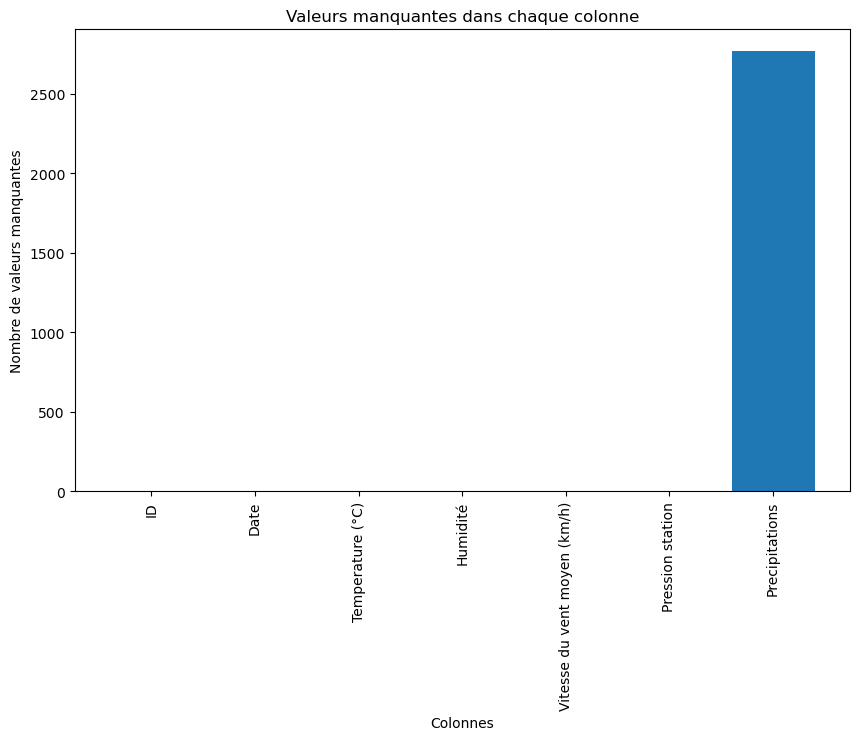

In [8]:
missing_values = df.isnull().sum()
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.xlabel('Colonnes')
plt.ylabel('Nombre de valeurs manquantes')
plt.title('Valeurs manquantes dans chaque colonne')
plt.xticks(rotation=90)
plt.show()

Evolution de la temperature au fur et à mesure des années

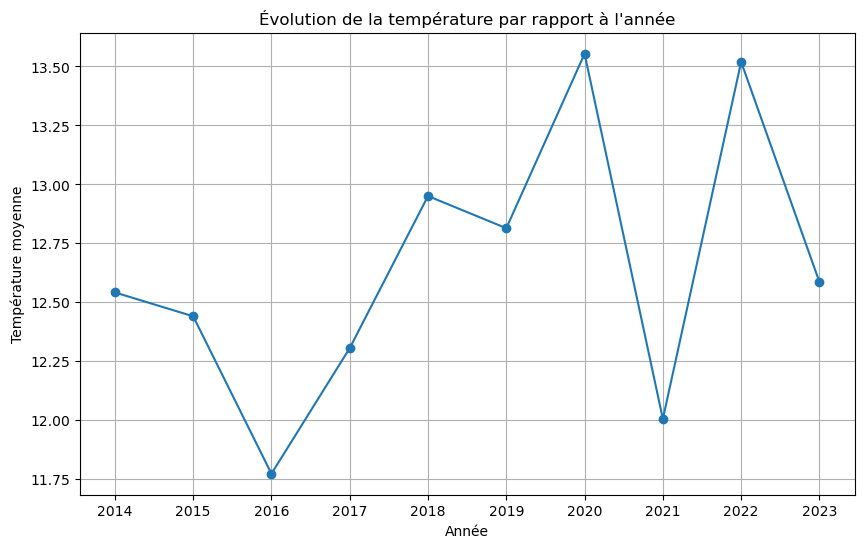

In [9]:
df['Year'] = pd.to_datetime(df['Date']).dt.year

temperature_par_annee = df.groupby('Year')['Temperature (°C)'].mean()
plt.figure(figsize=(10, 6))
plt.plot(temperature_par_annee.index, temperature_par_annee.values, marker='o', linestyle='-')
plt.xlabel('Année')
plt.ylabel('Température moyenne')
plt.title('Évolution de la température par rapport à l\'année')
plt.grid(True)
plt.xticks(temperature_par_annee.index)
plt.show()

In [10]:
df = pd.read_csv('data/dataset.csv', delimiter=';')

Nettoyage du Dataset de la colonne Précipitations

In [11]:
#Imputation par la moyenne
df['Precipitations'].fillna(df['Precipitations'].mean(), inplace=True)

Nettoyage de la colonne Temperature

In [12]:
null_values = df['Temperature (°C)'].isnull().sum()
print("Nombre de valeurs NaN dans la colonne de température :", null_values)

df.dropna(subset=['Temperature (°C)'], inplace=True)

Nombre de valeurs NaN dans la colonne de température : 1


Split données Train & Test

In [13]:
df['Date'] = pd.to_datetime(df['Date'])

date_split = pd.to_datetime('2022-12-31')
train_data = df[df['Date'] <= date_split]
test_data = df[df['Date'] > date_split]

train_data = TimeSeriesDataFrame(train_data)
test_data = TimeSeriesDataFrame(test_data)

Implémentation du modèle

In [15]:
target_column = 'Temperature (°C)'
ft_columns = ['Humidité', 'Vitesse du vent moyen (km/h)', 'Pression station', 'Precipitations']

model_predict = TimeSeriesPredictor(prediction_length=3, path="model/timeseries_model", target="Temperature (°C)", eval_metric="MASE")

Entraînement

In [1]:
model_predict.fit(train_data, presets="medium_quality")

NameError: name 'model_predict' is not defined

_Evaluation de la performance sur les données Test

In [ ]:
model_predict.leaderboard(test_data, silent=True)

Prediction de la temperature des 3 prochains jours

In [ ]:
predictions = model_predict.predict(train_data)